In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [2]:
import yfinance as yf

In [3]:
#Download Tata motors data from yahoo finance
df = yf.download('RELIANCE.NS')

[*********************100%***********************]  1 of 1 completed


In [4]:
#first 5 samples
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,15.859429,15.944529,15.754989,15.917452,10.477991,48051995
1996-01-02,15.878770,15.956133,15.677626,15.793671,10.396510,77875009
1996-01-03,16.052837,16.783918,15.878770,15.913584,10.475447,96602936
1996-01-04,15.762726,15.813012,15.553845,15.766594,10.378686,100099436
1996-01-05,15.704703,15.704703,15.522900,15.658285,10.307389,76935930


In [5]:
# to check dates in index
df.index

DatetimeIndex(['1996-01-01', '1996-01-02', '1996-01-03', '1996-01-04',
               '1996-01-05', '1996-01-08', '1996-01-09', '1996-01-10',
               '1996-01-11', '1996-01-12',
               ...
               '2023-06-15', '2023-06-16', '2023-06-19', '2023-06-20',
               '2023-06-21', '2023-06-22', '2023-06-23', '2023-06-26',
               '2023-06-27', '2023-06-30'],
              dtype='datetime64[ns]', name='Date', length=6911, freq=None)

In [6]:
df.shape

(6911, 6)

In [7]:
# to check features or columns 
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [8]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-22,2556.000000,2573.300049,2532.000000,2535.500000,2535.500000,3516244
2023-06-23,2528.899902,2533.399902,2512.000000,2514.750000,2514.750000,3059084
2023-06-26,2507.000000,2515.399902,2488.699951,2495.550049,2495.550049,5833893
2023-06-27,2496.550049,2509.500000,2486.649902,2496.449951,2496.449951,4471687
2023-06-30,2546.399902,2556.649902,2533.449951,2550.250000,2550.250000,5144841


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6911 entries, 1996-01-01 to 2023-06-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6911 non-null   float64
 1   High       6911 non-null   float64
 2   Low        6911 non-null   float64
 3   Close      6911 non-null   float64
 4   Adj Close  6911 non-null   float64
 5   Volume     6911 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 377.9 KB


In [10]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

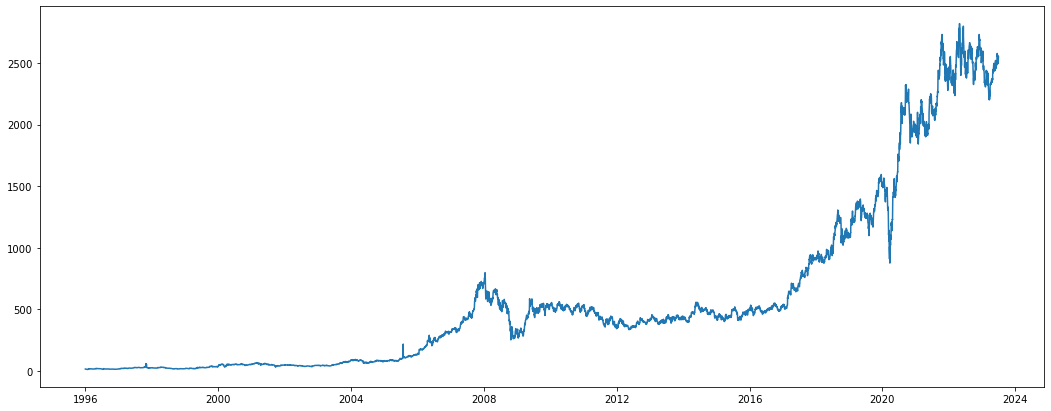

In [12]:
# plot a graph
plt1 = plt.figure(figsize=(18,7))
import matplotlib.pyplot as plt
plt.plot(df['Close'])

In [13]:
# check open price for first day and close price for last day
print("Starting price: ",df.iloc[0][0])
print("Ending price: ", df.iloc[-1][3])

Starting price:  15.859429359436035
Ending price:  2550.25


In [14]:
# check start date and end date in our dataset
print("Starting date: ",df.index[0])
print("Ending date: ", df.index[-1])

Starting date:  1996-01-01 00:00:00
Ending date:  2023-06-30 00:00:00


In [15]:
# drop some columns except 'close ' columns as we are going to do prediction only on closing price
df.drop(columns=['High','Low','Adj Close','Volume'],inplace=True)

In [16]:
df.head()

,Open,Close
Date,,
1996-01-01,15.859429,15.917452
1996-01-02,15.878770,15.793671
1996-01-03,16.052837,15.913584
1996-01-04,15.762726,15.766594
1996-01-05,15.704703,15.658285


In [17]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
# Preprocess the data
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df['Close']).reshape(-1,1))

In [18]:
df1

array([[0.00143405],
       [0.00138997],
       [0.00143267],
       ...,
       [0.88450686],
       [0.88482734],
       [0.90398718]])

In [19]:
# Split data into training and testing sets
train_size=int(len(df1)*0.7)
test_size=len(df1)-train_size
train_data,test_data=df1[0:train_size,:],df1[train_size:len(df1),:1]

In [20]:
train_size,test_size

(4837, 2074)

In [21]:
train_data

array([[0.00143405],
       [0.00138997],
       [0.00143267],
       ...,
       [0.15720926],
       [0.15593923],
       [0.16115165]])

In [22]:
# convert an array of values into a dataset matrix
#function to create new dataset which is required by LSTM.giving sequence of data to our LSTM model
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), numpy.array(dataY)

In [23]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
import numpy
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [24]:
X_train

array([[0.00143405, 0.00138997, 0.00143267, ..., 0.00018597, 0.        ,
        0.        ],
       [0.00138997, 0.00143267, 0.00138032, ..., 0.        , 0.        ,
        0.00033337],
       [0.00143267, 0.00138032, 0.00134175, ..., 0.        , 0.00033337,
        0.00074389],
       ...,
       [0.15295818, 0.1523849 , 0.15197037, ..., 0.15220851, 0.15258775,
        0.15572755],
       [0.1523849 , 0.15197037, 0.15025936, ..., 0.15258775, 0.15572755,
        0.15970521],
       [0.15197037, 0.15025936, 0.14324773, ..., 0.15572755, 0.15970521,
        0.15720926]])

In [25]:
y_train

array([0.00033337, 0.00074389, 0.00063506, ..., 0.15970521, 0.15720926,
       0.15593923])

In [26]:
X_test

array([[0.15959938, 0.15869978, 0.15626554, ..., 0.1482132 , 0.15466037,
        0.15237608],
       [0.15869978, 0.15626554, 0.15393715, ..., 0.15466037, 0.15237608,
        0.15186454],
       [0.15626554, 0.15393715, 0.15134418, ..., 0.15237608, 0.15186454,
        0.14916573],
       ...,
       [0.88840647, 0.89342795, 0.89319641, ..., 0.90642671, 0.90899083,
        0.89873426],
       [0.89342795, 0.89319641, 0.87537206, ..., 0.90899083, 0.89873426,
        0.89134455],
       [0.89319641, 0.87537206, 0.87300383, ..., 0.89873426, 0.89134455,
        0.88450686]])

In [27]:
print(X_train.shape) 

(4816, 20)


In [28]:
print(y_train.shape)

(4816,)


In [29]:
print(X_test.shape)

(2053, 20)


In [30]:
print(ytest.shape)

(2053,)


In [31]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [32]:
X_train.shape

(4816, 20, 1)

In [33]:
X_train

array([[[0.00143405],
        [0.00138997],
        [0.00143267],
        ...,
        [0.00018597],
        [0.        ],
        [0.        ]],

       [[0.00138997],
        [0.00143267],
        [0.00138032],
        ...,
        [0.        ],
        [0.        ],
        [0.00033337]],

       [[0.00143267],
        [0.00138032],
        [0.00134175],
        ...,
        [0.        ],
        [0.00033337],
        [0.00074389]],

       ...,

       [[0.15295818],
        [0.1523849 ],
        [0.15197037],
        ...,
        [0.15220851],
        [0.15258775],
        [0.15572755]],

       [[0.1523849 ],
        [0.15197037],
        [0.15025936],
        ...,
        [0.15258775],
        [0.15572755],
        [0.15970521]],

       [[0.15197037],
        [0.15025936],
        [0.14324773],
        ...,
        [0.15572755],
        [0.15970521],
        [0.15720926]]])

In [34]:
### Create the Stacked LSTM model
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model

In [35]:
#model=Sequential()
#model.add(LSTM(100, input_shape = (time_step , 1)))
#model.add(Dropout(0.2))
#model.add(LSTM(200, input_shape=(time_step , 1), return_sequences=False))
#model.add(Dropout(0.5))
#model.add(Dense(100,kernel_initializer='uniform',activation='sigmoid'))        
#model.add(Dense(1,kernel_initializer='uniform',activation='sigmoid'))
#model.compile(loss='mse',optimizer='adam')

model=Sequential()
model.add(LSTM(50,input_shape=(time_step,1)))
model.add(Dropout(0.2))
#model.add(LSTM(50,return_sequences=True))
#model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
151/151 [==============================] - 7s 24ms/step - loss: 5.7924e-04 - val_loss: 0.0032
Epoch 2/100
151/151 [==============================] - 3s 19ms/step - loss: 1.0075e-04 - val_loss: 3.7462e-04
Epoch 3/100
151/151 [==============================] - 3s 18ms/step - loss: 8.4617e-05 - val_loss: 8.4429e-04
Epoch 4/100
151/151 [==============================] - 3s 18ms/step - loss: 7.5373e-05 - val_loss: 0.0014
Epoch 5/100
151/151 [==============================] - 3s 18ms/step - loss: 6.7408e-05 - val_loss: 0.0018
Epoch 6/100
151/151 [==============================] - 3s 19ms/step - loss: 6.3375e-05 - val_loss: 0.0027
Epoch 7/100
151/151 [==============================] - 3s 19ms/step - loss: 5.5653e-05 - val_loss: 0.0017
Epoch 8/100
151/151 [==============================] - 3s 18ms/step - loss: 5.3831e-05 - val_loss: 0.0029
Epoch 9/100
151/151 [==============================] - 3s 18ms/step - loss: 5.6237e-05 - val_loss: 0.0035
Epoch 10/100
151/151 [================

151/151 [==============================] - 3s 19ms/step - loss: 3.8989e-05 - val_loss: 6.3030e-04
Epoch 77/100
151/151 [==============================] - 3s 20ms/step - loss: 3.7783e-05 - val_loss: 6.3689e-04
Epoch 78/100
151/151 [==============================] - 3s 19ms/step - loss: 4.0020e-05 - val_loss: 3.6875e-04
Epoch 79/100
151/151 [==============================] - 3s 19ms/step - loss: 3.8552e-05 - val_loss: 0.0012
Epoch 80/100
151/151 [==============================] - 3s 21ms/step - loss: 3.9532e-05 - val_loss: 6.2346e-04
Epoch 81/100
151/151 [==============================] - 4s 26ms/step - loss: 4.0195e-05 - val_loss: 2.2847e-04
Epoch 82/100
151/151 [==============================] - 3s 19ms/step - loss: 4.0005e-05 - val_loss: 6.2700e-04
Epoch 83/100
151/151 [==============================] - 3s 21ms/step - loss: 3.9123e-05 - val_loss: 5.3244e-04
Epoch 84/100
151/151 [==============================] - 3s 20ms/step - loss: 3.6509e-05 - val_loss: 9.0182e-04
Epoch 85/100
151/1

In [38]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

65/65 [==============================] - 0s 7ms/step


In [39]:
train_predict

array([[0.00096907],
       [0.00121848],
       [0.00160443],
       ...,
       [0.15456614],
       [0.15831897],
       [0.1569294 ]], dtype=float32)

In [40]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [41]:
train_predict

array([[ 14.611827],
       [ 15.312134],
       [ 16.39588 ],
       ...,
       [445.90616 ],
       [456.44394 ],
       [452.54208 ]], dtype=float32)

In [42]:
test_predict

array([[ 438.56955],
       [ 436.59863],
       [ 430.1876 ],
       ...,
       [2413.8538 ],
       [2396.2463 ],
       [2380.268  ]], dtype=float32)

In [43]:
ytest

array([0.15186454, 0.14916573, 0.14731359, ..., 0.89134455, 0.88450686,
       0.88482734])

In [44]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))


307.5373952810168

In [45]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

1532.2113328179973

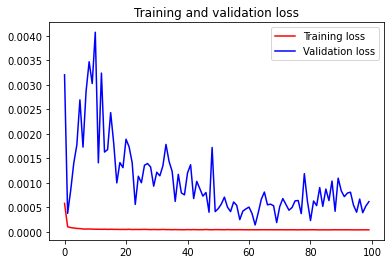

<Figure size 432x288 with 0 Axes>

In [46]:
### plot a graph for training and validation loss to visualize the results of model training

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.figure()


plt.show()

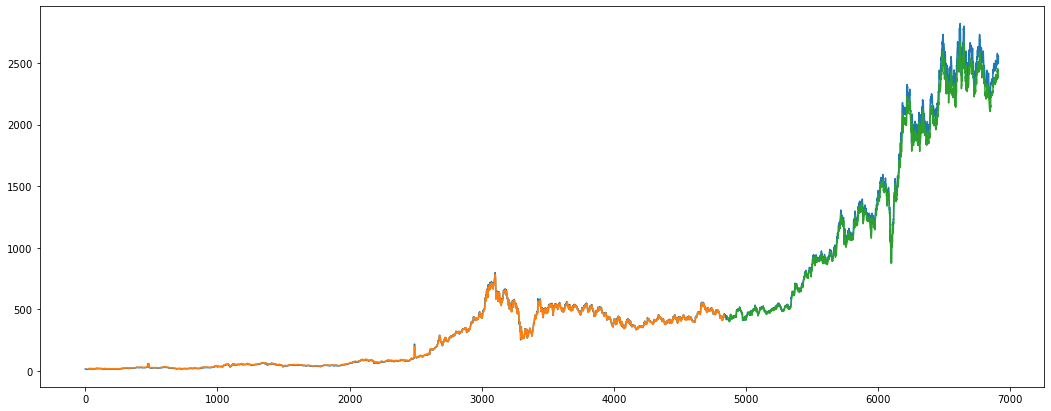

In [47]:
# shift train predictions for plotting
look_back=20
trainPredictPlot = numpy.empty_like(df1)  ## to take same shape and sata type of df1
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt1 = plt.figure(figsize=(18,7))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [48]:
ytest

array([0.15186454, 0.14916573, 0.14731359, ..., 0.89134455, 0.88450686,
       0.88482734])

In [49]:
test_predict

array([[ 438.56955],
       [ 436.59863],
       [ 430.1876 ],
       ...,
       [2413.8538 ],
       [2396.2463 ],
       [2380.268  ]], dtype=float32)

In [50]:
test_predict1 = test_predict.flatten()

In [51]:
len(ytest)

2053

In [52]:
test_predict1

array([ 438.56955,  436.59863,  430.1876 , ..., 2413.8538 , 2396.2463 ,
       2380.268  ], dtype=float32)

In [53]:
ytest1 = ytest.flatten()

In [54]:
ytest1 = ytest1.reshape(1,-1)

In [55]:
ytest1

array([[0.15186454, 0.14916573, 0.14731359, ..., 0.89134455, 0.88450686,
        0.88482734]])

In [56]:
ytest2 = scaler.inverse_transform(ytest1)

In [57]:
ytest2

array([[ 438.32015991,  430.74200439,  425.54129028, ..., 2514.75      ,
        2495.55004883, 2496.44995117]])

In [58]:
ytest2 = ytest2.flatten()

In [59]:
len(ytest2)

2053

In [60]:
df2 = df.iloc[4858:,:]

In [61]:
len(df2)

2053

In [62]:
df2.head()

,Open,Close
Date,,
2015-03-09,438.394470,430.742004
2015-03-10,430.395294,425.541290
2015-03-11,426.432831,423.956329
2015-03-12,424.971680,427.844452
2015-03-13,430.420044,421.058777


In [63]:
df2['predicted'] = test_predict1

In [64]:
df2.head(20)

,Open,Close,predicted
Date,,,
2015-03-09,438.394470,430.742004,438.569550
2015-03-10,430.395294,425.541290,436.598633
2015-03-11,426.432831,423.956329,430.187592
2015-03-12,424.971680,427.844452,424.855591
2015-03-13,430.420044,421.058777,422.734283
2015-03-16,421.752197,417.096344,425.618713
2015-03-17,421.281677,424.402100,420.697693
2015-03-18,424.476379,430.246704,416.309021
2015-03-19,433.664307,424.055389,421.417114


In [65]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2053 entries, 2015-03-09 to 2023-06-30
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2053 non-null   float64
 1   Close      2053 non-null   float64
 2   predicted  2053 non-null   float32
dtypes: float32(1), float64(2)
memory usage: 56.1 KB


In [66]:
df2.tail()

,Open,Close,predicted
Date,,,
2023-06-22,2556.000000,2535.500000,2436.707764
2023-06-23,2528.899902,2514.750000,2444.913330
2023-06-26,2507.000000,2495.550049,2413.853760
2023-06-27,2496.550049,2496.449951,2396.246338
2023-06-30,2546.399902,2550.250000,2380.268066


In [67]:
df2['temp_signal'] = df2['predicted'] - df2['Close']

In [68]:
df2.head()

,Open,Close,predicted,temp_signal
Date,,,,
2015-03-09,438.394470,430.742004,438.569550,7.827545
2015-03-10,430.395294,425.541290,436.598633,11.057343
2015-03-11,426.432831,423.956329,430.187592,6.231262
2015-03-12,424.971680,427.844452,424.855591,-2.988861
2015-03-13,430.420044,421.058777,422.734283,1.675507


In [69]:
df2['signal'] = df2['temp_signal'].apply(lambda x:1 if x>0 else 0)

In [70]:
df2.head()

,Open,Close,predicted,temp_signal,signal
Date,,,,,
2015-03-09,438.394470,430.742004,438.569550,7.827545,1
2015-03-10,430.395294,425.541290,436.598633,11.057343,1
2015-03-11,426.432831,423.956329,430.187592,6.231262,1
2015-03-12,424.971680,427.844452,424.855591,-2.988861,0
2015-03-13,430.420044,421.058777,422.734283,1.675507,1


In [71]:
df2.drop(columns='temp_signal',inplace = True)

In [72]:
df2.head()

,Open,Close,predicted,signal
Date,,,,
2015-03-09,438.394470,430.742004,438.569550,1
2015-03-10,430.395294,425.541290,436.598633,1
2015-03-11,426.432831,423.956329,430.187592,1
2015-03-12,424.971680,427.844452,424.855591,0
2015-03-13,430.420044,421.058777,422.734283,1


In [73]:
signal = list(df2['signal'])

In [74]:
signal

[1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,


In [75]:
signal.insert(0,999)

In [76]:
signal

[999,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0

In [77]:
len(df2)

2053

In [78]:
len(signal)

2054

In [79]:
signal.pop()

0

In [80]:
len(signal)

2053

In [81]:
new_signal = np.array(signal)

In [82]:
new_signal

array([999,   1,   1, ...,   0,   0,   0])

In [83]:
df2['new_signal'] = new_signal

In [84]:
df2.head()

,Open,Close,predicted,signal,new_signal
Date,,,,,
2015-03-09,438.394470,430.742004,438.569550,1,999
2015-03-10,430.395294,425.541290,436.598633,1,1
2015-03-11,426.432831,423.956329,430.187592,1,1
2015-03-12,424.971680,427.844452,424.855591,0,1
2015-03-13,430.420044,421.058777,422.734283,1,0


In [85]:
df2.drop(columns = 'signal',inplace = True)

In [86]:
df3 = df2[df2['new_signal']==1]

In [87]:
df3.head()

,Open,Close,predicted,new_signal
Date,,,,
2015-03-10,430.395294,425.541290,436.598633,1
2015-03-11,426.432831,423.956329,430.187592,1
2015-03-12,424.971680,427.844452,424.855591,1
2015-03-16,421.752197,417.096344,425.618713,1
2015-03-17,421.281677,424.402100,420.697693,1


In [88]:
df3['profit_loss'] = df3['Close'] - df3['Open']

In [89]:
df3.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2015-03-10,430.395294,425.541290,436.598633,1,-4.854004
2015-03-11,426.432831,423.956329,430.187592,1,-2.476501
2015-03-12,424.971680,427.844452,424.855591,1,2.872772
2015-03-16,421.752197,417.096344,425.618713,1,-4.655853
2015-03-17,421.281677,424.402100,420.697693,1,3.120422


In [90]:
df3['profit_loss'].sum()

162.38507080078125

In [93]:
df4 = df2[df2['new_signal']==0]

In [96]:
df4['profit_loss'] = df4['Open'] - df4['Close']

In [97]:
df4.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2015-03-13,430.420044,421.058777,422.734283,0,9.361267
2015-03-18,424.476379,430.246704,416.309021,0,-5.770325
2015-03-19,433.664307,424.055389,421.417114,0,9.608917
2015-03-20,424.922150,423.040009,427.331207,0,1.882141
2015-03-26,416.601044,410.756439,417.862305,0,5.844604


In [100]:
df2.head()

,Open,Close,predicted,new_signal
Date,,,,
2015-03-09,438.394470,430.742004,438.569550,999
2015-03-10,430.395294,425.541290,436.598633,1
2015-03-11,426.432831,423.956329,430.187592,1
2015-03-12,424.971680,427.844452,424.855591,1
2015-03-13,430.420044,421.058777,422.734283,0


In [101]:
df2.tail()

,Open,Close,predicted,new_signal
Date,,,,
2023-06-22,2556.000000,2535.500000,2436.707764,0
2023-06-23,2528.899902,2514.750000,2444.913330,0
2023-06-26,2507.000000,2495.550049,2413.853760,0
2023-06-27,2496.550049,2496.449951,2396.246338,0
2023-06-30,2546.399902,2550.250000,2380.268066,0


In [98]:
df4['profit_loss'].sum()

2450.3302307128906

In [102]:
Total_profit = df4['profit_loss'].sum() + df3['profit_loss'].sum()

In [103]:
Total_profit

2612.715301513672

In [104]:
# check open price for first day and close price for last day
print("Starting price: ",df2.iloc[0][0])
print("Ending price: ", df2.iloc[-1][2])

Starting price:  438.39447021484375
Ending price:  2380.26806640625


In [105]:
# total profit if buy and hold

buy_hold_profit = df2.iloc[-1][2] - df2.iloc[0][0]
buy_hold_profit

1941.8735961914062

In [106]:
# excess profit generated by algo model

excess_profit = Total_profit - buy_hold_profit
excess_profit

670.8417053222656

In [107]:
# excess profit in percent

excess_profit_percent = (excess_profit *100)/Total_profit
excess_profit_percent

25.676035384858608

In [91]:
len(df3)

344

In [99]:
len(df4)

1708

In [92]:
len(df2)

2053